In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib, random
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Tue Feb 17 00:25:15 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:61:00.0 Off |                  Off |
| 30%   29C    P8             10W /  300W |       5MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
config = project.core.fileio.load_config('2026-02-02_config.yaml')

Loading 2026-02-02_config.yaml


In [6]:
data_config = config['dataset'].copy()
data_config

#data_config['examples']['subjects'] = 'one_subject.csv'
#data_config['examples']['subjects'] = 'two_subjects.csv'
data_config['examples']['subjects'] = 'ten_subjects.csv'
#data_config['examples']['subjects'] = '100_subjects.csv'
#data_config['examples']['subjects'] = '2026-01-26_preprocessed.csv'

data_config['selectors']['input_image'] = 'mean_std-1'

In [73]:
examples = project.api.get_examples(config['dataset'])
len(examples)

Gathering examples


100

In [74]:
ex = np.random.choice(examples)
pprint(ex)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.2d17f0548116c3d143c8f1cd479ffb1e'
├── variant:  '2026-01-15'
├── paths:    dict(len=13)
|   ├── 'source_mesh':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-OBJ/models/2d17f0548116c3d143c8f1cd479ffb1e.obj')
|   ├── 'source_mask':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/models-binvox-solid/2d17f0548116c3d143c8f1cd479ffb1e.binvox')
|   ├── 'binary_mask':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2d17f0548116c3d143c8f1cd479ffb1e/masks/mask.nii.gz')
|   ├── 'region_mask':   PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2d17f0548116c3d143c8f1cd479ffb1e/masks/mask_regions.nii.gz')
|   ├── 'material_mask': PosixPath('/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2d17f0548116c3d143c8f1cd479ffb1e/masks/mask_regions_uniform-seed.nii.gz')
|   ├── 

Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2d17f0548116c3d143c8f1cd479ffb1e/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2d17f0548116c3d143c8f1cd479ffb1e/images/mask_regions_uniform-seed_mean_std-1.nii.gz
-0.002140038130453246
0.8052813352710081


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/visual/matplotlib.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9459179639816284..1.6911276578903198].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7637463808059692..1.719687581062317].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8380919694900513..1.716141939163208].


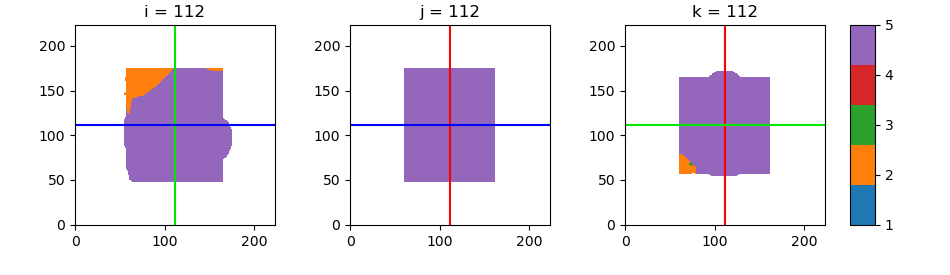

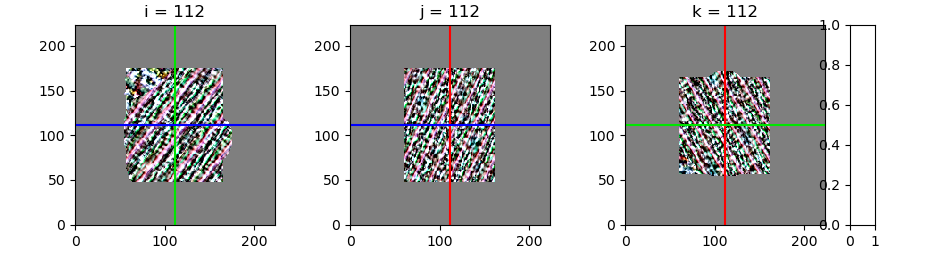

In [75]:
%autoreload
import project.visual.matplotlib as mpl_viz

mask = project.core.fileio.load_nibabel(ex.paths['material_mask']).get_fdata()
image = project.core.fileio.load_nibabel(ex.paths['input_image']).get_fdata()

print(image[mask > 0].mean())
print(image[mask > 0].std())

mpl_viz.SliceViewer(mask, **mpl_viz.get_color_kws('material', n_labels=5))
mpl_viz.SliceViewer((image + 1)/2)

In [76]:
rgb = (image.ndim == 4 and image.shape[-1] == 3)
rgb

True

In [77]:
train_config = config['training'].copy()
project.core.utils.pprint(train_config, 2, 100)

dict(len=9)
├── 'task':            dict(len=3)
|   ├── 'inputs':  list(len=1)
|   ├── 'targets': list(len=1)
|   └── 'losses':  dict(len=1)
├── 'split':           dict(len=4)
|   ├── 'key':        'category'
|   ├── 'test_ratio': 0.2
|   ├── 'val_ratio':  0.1
|   └── 'seed':       0
├── 'transform':       dict(len=5)
|   ├── 'normalize':  True
|   ├── 'image_mean': 1.0
|   ├── 'image_std':  1.0
|   ├── 'apply_mask': True
|   └── 'do_augment': True
├── 'loader':          dict(len=6)
|   ├── 'batch_size':         1
|   ├── 'shuffle':            True
|   ├── 'num_workers':        2
|   ├── 'persistent_workers': True
|   ├── 'prefetch_factor':    2
|   └── 'pin_memory':         True
├── 'model':           dict(len=2)
|   ├── 'backbone': dict(len=11)
|   └── 'heads':    dict(len=2)
├── 'physics_adapter': dict(len=4)
|   ├── 'default_nu':    0.4
|   ├── 'default_rho':   1000
|   ├── 'scalar_degree': 1
|   └── 'vector_degree': 1
├── 'pde_solver':      dict(len=2)
|   ├── '_class':        'War

In [78]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [79]:
import project.training
split_kws = train_config['split']
train_ex, test_ex, val_ex = project.training.split_on_metadata(examples, **split_kws)

len(train_ex), len(test_ex), len(val_ex)

Splitting examples
Test categories: {'Recliner', 'DoubleBed', 'RubiksCube', 'CeilingLamp', 'TableClock', 'DiscCase', 'FoodItem', 'Copier', 'Refrigerator', 'DrinkBottle', 'Bed', 'ToyFigure', 'Bathtub', 'Computer', 'Microwave', 'Ball', 'Book', 'CellPhone', 'TableLamp', 'MediaStorage', 'Calculator', 'CurioCabinet', 'VideoGameController'}
Test subjects:   {'wss.2682cb34e7db8735bdc7fd7cf135ade2', 'wss.29f66488d7507b0c5a93c9a5a7a08569', 'wss.2725909a09e1a7961df58f4da76e254b', 'wss.1fd8d3cdf525532b5b5a685c28abd3e', 'wss.28cae57a8d9f858b92eb9b3d545b01bd', 'wss.1d2a6082238f011c22d3f170937c6a0b', 'wss.2936cf91218a53dee04e4d5188c661b9', 'wss.263aa26d579b6def14c06184923f6962', 'wss.13b48456dad49f8762edbb9e1af21a03', 'wss.20dec770602a8ac2331999dc8823fe0d', 'wss.266aba6a1b941c3a2bf3161ae4fda942', 'wss.2b78edd5bc31b19ae0681a1280473149', 'wss.25370f9a01166beaa13edbe825cc0113', 'wss.24505c53438f8273399f45f7c8fcdfa9', 'wss.29830fb806fe23b29ccf01d06bf2094d', 'wss.2acb67458c17af08c4b494041bc63422', 'wss.2

(68, 20, 10)

In [80]:
transform_kws = train_config['transform'].copy()

transform_kws['normalize']  = True
transform_kws['image_mean'] = 0.0
transform_kws['image_std']  = 1.0
transform_kws['apply_mask'] = True

transform_kws['do_augment']   = True
transform_kws['rand_rotate']  = True
transform_kws['rand_reflect'] = True
transform_kws['sigma_trans']  = 4.0

transform_kws

{'normalize': True,
 'image_mean': 0.0,
 'image_std': 1.0,
 'apply_mask': True,
 'do_augment': True,
 'rand_rotate': True,
 'rand_reflect': True,
 'sigma_trans': 4.0}

In [81]:
%autoreload
import project.datasets.torch

use_cache = len(examples) < 100
train_set = project.datasets.torch.TorchDataset(train_ex, use_cache=use_cache, rgb=rgb, **transform_kws)
test_set = project.datasets.torch.TorchDataset(test_ex, use_cache=use_cache, rgb=rgb, **transform_kws)
val_set = project.datasets.torch.TorchDataset(val_ex, use_cache=use_cache, rgb=rgb, **transform_kws)

In [82]:
loader_kws = train_config['loader'].copy()
loader_kws = {'batch_size': 1, 'num_workers': 0}
loader_kws

{'batch_size': 1, 'num_workers': 0}

In [83]:
collate_fn = project.datasets.torch.collate_fn
train_loader = torch.utils.data.DataLoader(train_set, collate_fn=collate_fn, **loader_kws)

if test_set:
    test_loader = torch.utils.data.DataLoader(test_set, collate_fn=collate_fn, **loader_kws)
else:
    test_loader = None

if val_set:
    val_loader = torch.utils.data.DataLoader(val_set, collate_fn=collate_fn, **loader_kws)
else:
    val_loader = None


In [84]:
import project.training

task_kws = train_config['task'].copy()

task_kws['inputs']  = ['image']
task_kws['targets'] = ['E']
task_kws['losses']  = {'E': 'sim'}

task = project.training.TaskSpec(rgb=rgb, **task_kws)

Inputs:  ['image']
Targets: ['E']
Losses:  {'E': 'sim'}


In [85]:
import copy
model_kws = copy.deepcopy(train_config['model'])

project.core.utils.pprint(model_kws, 3, 20)

dict(len=2)
├── 'backbone': dict(len=11)
|   ├── '_class':        'UNet3Dv2'
|   ├── 'out_channels':  16
|   ├── 'conv_channels': 16
|   ├── 'n_conv_units':  2
|   ├── 'n_sub_levels':  2
|   ├── 'kernel_size':   3
|   ├── 'relu_leak':     0.1
|   ├── 'norm_type':     'group'
|   ├── 'num_groups':    4
|   ├── 'pooling_type':  'max'
|   └── 'upsample_mode': 'trilinear'
└── 'heads':    dict(len=2)
    ├── 'E':  dict(len=5)
    |   ├── 'param_mode': 'log10'
    |   ├── 'param_mean': 3.4863
    |   ├── 'param_std':  0.3271
    |   ├── 'param_min':  0.0
    |   └── 'param_max':  6.0
    └── 'nu': dict(len=3)
        ├── 'param_mode': 'logit'
        ├── 'param_min':  0.0
        └── 'param_max':  0.5


In [86]:
%autoreload
import project.models
model = project.models.build_model(task, model_kws)
model

MultiTaskModel(
  (backbone): UNet3Dv2(
    (enc): ConvBlock3D(
      (unit0): ConvUnit3D(
        (conv): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
      (unit1): ConvUnit3D(
        (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
        (norm): GroupNorm(4, 16, eps=1e-05, affine=True)
        (act): LeakyReLU(negative_slope=0.1, inplace=True)
      )
    )
    (down): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (sub): UNet3Dv2(
      (enc): ConvBlock3D(
        (unit0): ConvUnit3D(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=same, bias=False, padding_mode=replicate)
          (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
          (act): LeakyReLU(negative_slo

In [87]:
project.models.count_params(model)

backbone.enc.unit0.conv.weight                     1296	(16, 3, 3, 3, 3)
backbone.enc.unit0.norm.weight                     16	(16,)
backbone.enc.unit0.norm.bias                       16	(16,)
backbone.enc.unit1.conv.weight                     6912	(16, 16, 3, 3, 3)
backbone.enc.unit1.norm.weight                     16	(16,)
backbone.enc.unit1.norm.bias                       16	(16,)
backbone.sub.enc.unit0.conv.weight                 13824	(32, 16, 3, 3, 3)
backbone.sub.enc.unit0.norm.weight                 32	(32,)
backbone.sub.enc.unit0.norm.bias                   32	(32,)
backbone.sub.enc.unit1.conv.weight                 27648	(32, 32, 3, 3, 3)
backbone.sub.enc.unit1.norm.weight                 32	(32,)
backbone.sub.enc.unit1.norm.bias                   32	(32,)
backbone.sub.sub.enc.unit0.conv.weight             55296	(64, 32, 3, 3, 3)
backbone.sub.sub.enc.unit0.norm.weight             64	(64,)
backbone.sub.sub.enc.unit0.norm.bias               64	(64,)
backbone.sub.sub.enc.unit1.c

472129

In [88]:
pde_solver_kws = train_config['pde_solver'].copy()
pde_solver_kws['use_relative'] = True
pde_solver_kws

{'_class': 'WarpFEMSolver', 'tv_reg_weight': 0.0001, 'use_relative': True}

In [64]:
import project.physics

pde_solver_cls = pde_solver_kws.pop('_class')

physics_adapter = project.physics.PhysicsAdapter(
    pde_solver_cls=pde_solver_cls,
    pde_solver_kws=pde_solver_kws,
    **train_config['physics_adapter']
)
physics_adapter

In [89]:
import torch.optim
optimizer_kws = train_config['optimizer'].copy()
optimizer_kws['lr'] = 1e-3
optimizer_cls = getattr(torch.optim, optimizer_kws.pop('_class'))
optimizer = optimizer_cls(model.parameters(), **optimizer_kws)

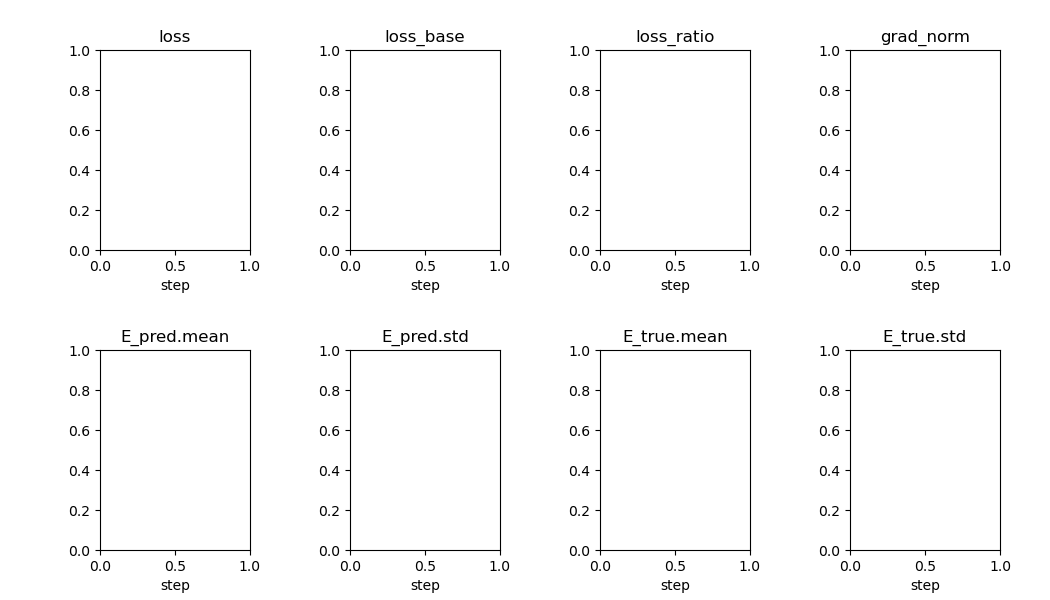

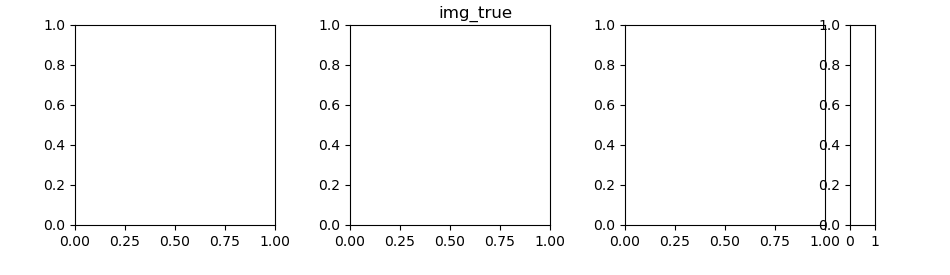

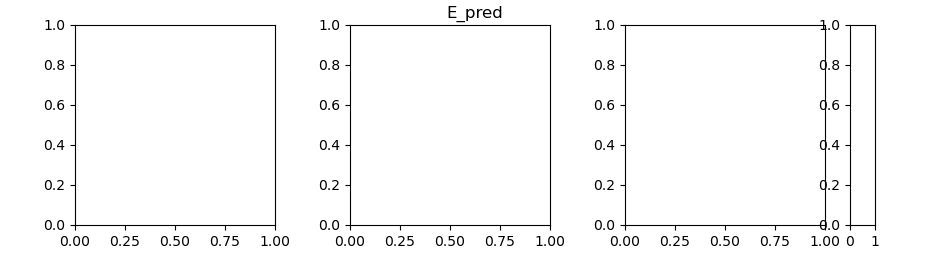

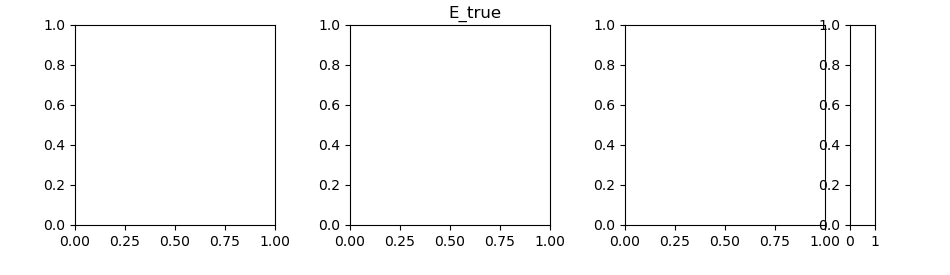

In [90]:
%autoreload
import project.training
import project.evaluation

trainer_kws = train_config['trainer'].copy()

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

callbacks = [
    project.evaluation.LoggerCallback(task.metric_keys),
    project.evaluation.PlotterCallback(task.metric_keys),
    project.evaluation.ViewerCallback(task.viewer_keys, apply_mask=True),
    project.evaluation.EvaluatorCallback(),
    project.evaluation.TimerCallback(),
]

trainer = project.training.Trainer(
    task=task,
    model=model,
    optimizer=optimizer,
    physics_adapter=physics_adapter,
    train_loader=train_loader,
    test_loader=test_loader,
    val_loader=val_loader,
    callbacks=callbacks
)

In [91]:
%autoreload
#trainer.load_state(epoch=0)
trainer.train(num_epochs=100, val_every=1)

Start training
Start epoch 0
Saving checkpoints/checkpoint00000.pt
Start epoch 0 val phase
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d054ec740f09093bc41182b106c7bda/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d054ec740f09093bc41182b106c7bda/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d054ec740f09093bc41182b106c7bda/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d054ec740f09093bc41182b106c7bda/fields/mask_regions_uniform-seed_elastic.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d054ec740f09093bc41182b106c7bda/fields/mask_regions_uniform-seed_density.nii.gz
[Epoch 0 | Val batch 0] start
load_data: {'t_delta': 2.4177, 'curr_a

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/evaluation.py:194: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


plotter: {'t_delta': 0.6537, 'curr_alloc': 1.2013, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2014, 'peak_rsvd': 18.3828}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54327846..1.9037449].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38661742..1.6713887].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4858654..1.8822459].
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/../../project/visual/matplotlib.py:103: UserWarning: Adding colorbar to a different Figure <Figure size 1662.5x481.25 with 4 Axes> than <Figure size 1662.5x481.25 with 4 Axes> which fig.colorbar is called on.
  plt.colorbar(self.im_k, cax=self.cbar_ax)


viewer: {'t_delta': 0.4295, 'curr_alloc': 1.2013, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2013, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.4237, 'curr_alloc': 1.2013, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2013, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0013, 'curr_alloc': 1.2013, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2013, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9012023..1.8466218].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.043315..2.6359832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0565087..2.0387287].


viewer: {'t_delta': 0.413, 'curr_alloc': 1.2049, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2049, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 2.0947, 'curr_alloc': 1.2049, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2049, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0013, 'curr_alloc': 1.2049, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2049, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8178539..2.5808804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0398107..2.6152415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95110726..1.98954].


viewer: {'t_delta': 0.406, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.8869, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0011, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6531509..1.6973796].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55579126..1.7361377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5080317..2.0425842].


viewer: {'t_delta': 0.3867, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.5146, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0011, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59058833..2.3397298].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7063049..2.915717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8490794..2.9252524].


viewer: {'t_delta': 0.3854, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 2.4653, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0011, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55494714..1.6842413].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.73217463..2.3477783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5759313..1.8488051].


viewer: {'t_delta': 0.3869, 'curr_alloc': 1.2052, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2052, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.4902, 'curr_alloc': 1.2052, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2052, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0016, 'curr_alloc': 1.2052, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2052, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3914947..1.5735211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6227857..1.4765186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59080434..1.6579574].


viewer: {'t_delta': 0.3821, 'curr_alloc': 1.2055, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2055, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 2.1335, 'curr_alloc': 1.2055, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2055, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2055, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2055, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66493535..2.6961176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89498603..2.342636].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.72179425..2.312882].


viewer: {'t_delta': 0.3995, 'curr_alloc': 1.205, 'curr_rsvd': 18.3828, 'peak_alloc': 1.205, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.715, 'curr_alloc': 1.205, 'curr_rsvd': 18.3828, 'peak_alloc': 1.205, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.001, 'curr_alloc': 1.205, 'curr_rsvd': 18.3828, 'peak_alloc': 1.205, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_uniform-see

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.510623..1.7756128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49753696..1.8854592].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45656973..1.7564328].


viewer: {'t_delta': 0.389, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.4301, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0016, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1393002..2.277472].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8862171..2.2447176].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.996896..2.1530151].


viewer: {'t_delta': 0.4091, 'curr_alloc': 1.207, 'curr_rsvd': 18.3828, 'peak_alloc': 1.207, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 2.0089, 'curr_alloc': 1.207, 'curr_rsvd': 18.3828, 'peak_alloc': 1.207, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0038, 'curr_alloc': 1.207, 'curr_rsvd': 18.3828, 'peak_alloc': 1.207, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_uniform-s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.037087..2.6294727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84310484..2.3151336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9975891..1.727896].


viewer: {'t_delta': 0.3957, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.9086, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0017, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62198496..1.7223544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5335864..1.7798908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7829716..1.8288196].


viewer: {'t_delta': 0.3915, 'curr_alloc': 1.206, 'curr_rsvd': 18.3828, 'peak_alloc': 1.206, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.4697, 'curr_alloc': 1.206, 'curr_rsvd': 18.3828, 'peak_alloc': 1.206, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.206, 'curr_rsvd': 18.3828, 'peak_alloc': 1.206, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uniform-s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55795383..2.0860293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6459236..2.3308742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56509864..2.3775623].


viewer: {'t_delta': 0.3843, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 2.2674, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5291934..1.7384214].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6273899..2.2696218].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7335118..2.28516].


viewer: {'t_delta': 0.3798, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.4234, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8135303..2.06963].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46947563..1.5137193].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8453944..1.515849].


viewer: {'t_delta': 0.3823, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.9873, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69235444..2.4564023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7371745..2.2138796].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6842749..2.068509].


viewer: {'t_delta': 0.3931, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.7198, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58961666..1.6387644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5953306..1.7631552].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62681925..1.7248944].


viewer: {'t_delta': 0.3848, 'curr_alloc': 1.2064, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2064, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.3431, 'curr_alloc': 1.2064, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2064, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0017, 'curr_alloc': 1.2064, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2064, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99096096..2.2051392].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98967135..2.109023].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.771827..2.705861].


viewer: {'t_delta': 0.409, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 2.0357, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0041, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.93507016..2.296371].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.97564185..2.5850234].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0739104..2.3337555].


viewer: {'t_delta': 0.3999, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.9064, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66550624..2.0353446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6893654..2.2263184].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5963253..1.7370446].


viewer: {'t_delta': 0.3912, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.4858, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86216426..2.1917067].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58683133..2.4449248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5720575..2.1421976].


viewer: {'t_delta': 0.394, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 2.2486, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0013, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform-

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.624594..2.2958307].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60722125..1.929394].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55337274..1.4569292].


viewer: {'t_delta': 0.3876, 'curr_alloc': 1.2061, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2061, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.5039, 'curr_alloc': 1.2061, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2061, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0014, 'curr_alloc': 1.2061, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2061, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5853518..1.9058758].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60455585..1.7992722].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6514733..1.52443].


viewer: {'t_delta': 0.4581, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.9895, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69824445..2.5528915].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7882801..2.5115774].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66537094..1.88888].


viewer: {'t_delta': 0.3995, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.7297, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3828, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.433132..1.679849].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52079964..1.6272867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7053175..1.7145202].


viewer: {'t_delta': 0.3887, 'curr_alloc': 1.206, 'curr_rsvd': 18.3828, 'peak_alloc': 1.206, 'peak_rsvd': 18.3828}
evaluator: {'t_delta': 1.4201, 'curr_alloc': 1.206, 'curr_rsvd': 18.3828, 'peak_alloc': 1.206, 'peak_rsvd': 18.3828}
timer: {'t_delta': 0.0017, 'curr_alloc': 1.206, 'curr_rsvd': 18.3828, 'peak_alloc': 1.206, 'peak_rsvd': 18.3828}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uniform-s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1081517..2.60643].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1166773..2.3411098].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9657184..2.0980682].


viewer: {'t_delta': 0.4108, 'curr_alloc': 1.2049, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2049, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.0376, 'curr_alloc': 1.2049, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2049, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0011, 'curr_alloc': 1.2049, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2049, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9248091..1.895239].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1131449..2.8204112].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9854108..3.2410822].


viewer: {'t_delta': 0.4071, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.8923, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5131736..1.9141649].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6238713..1.9414567].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58759296..1.7440804].


viewer: {'t_delta': 0.3891, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4704, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0011, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8096353..2.412253].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61436856..2.2928019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68478155..2.373907].


viewer: {'t_delta': 0.3837, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2824, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0016, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50335646..2.237914].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3762396..1.5458983].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5709859..1.6097827].


viewer: {'t_delta': 0.386, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4303, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79445946..2.2690926].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48333198..1.615452].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51584065..2.001061].


viewer: {'t_delta': 0.3744, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9801, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.87539697..1.856857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9520494..2.5718746].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6480503..2.1102362].


viewer: {'t_delta': 0.3959, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.7152, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5259408..1.7716408].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55201447..1.4967517].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4603603..1.9260353].


viewer: {'t_delta': 0.3916, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4185, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1433008..2.2568622].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0723407..1.9722345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0314922..2.3626757].


viewer: {'t_delta': 0.4084, 'curr_alloc': 1.2075, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2075, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.0018, 'curr_alloc': 1.2075, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2075, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.002, 'curr_alloc': 1.2075, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2075, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1128545..1.7935587].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1686214..2.5802183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0657463..2.4647694].


viewer: {'t_delta': 0.4009, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9107, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0015, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.57297325..1.8620859].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.547279..1.9268792].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6763686..2.014953].


viewer: {'t_delta': 0.3992, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4739, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59340763..2.1848764].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.43244046..2.770169].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8999386..2.4625046].


viewer: {'t_delta': 0.3938, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2801, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0014, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6072136..1.7313339].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6941639..2.3084278].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5575111..1.8309515].


viewer: {'t_delta': 0.3883, 'curr_alloc': 1.2064, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2064, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4339, 'curr_alloc': 1.2064, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2064, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0014, 'curr_alloc': 1.2064, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2064, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4256099..1.9905653].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8091178..1.8117335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.623824..1.3773849].


viewer: {'t_delta': 0.3833, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9939, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0033, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75140977..2.537642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75717986..2.5744731].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6604053..2.8974273].


viewer: {'t_delta': 0.3971, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.7113, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0019, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4968663..1.6867305].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62805545..1.7680104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5229378..1.5823087].


viewer: {'t_delta': 0.3898, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.3607, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0014, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uniform-s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0903399..2.3997717].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.170914..2.1761894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91409326..2.070961].


viewer: {'t_delta': 0.4157, 'curr_alloc': 1.2079, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2079, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9965, 'curr_alloc': 1.2079, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2079, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.004, 'curr_alloc': 1.2079, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2079, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99526954..2.4900556].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1619431..2.297727].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9515796..2.1834855].


viewer: {'t_delta': 0.3988, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.8876, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6012161..1.8627683].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5778096..1.8746529].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.559481..1.8867712].


viewer: {'t_delta': 0.3917, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4915, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0019, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69480014..2.516002].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.63696826..3.0669143].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8502809..2.2263374].


viewer: {'t_delta': 0.3867, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2776, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0015, 'curr_alloc': 1.2056, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2056, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6946672..2.3105295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.53435266..2.190059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58494234..2.4404004].


viewer: {'t_delta': 0.3797, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4478, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32995087..1.6570772].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5400388..1.8082654].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71390736..2.0575].


viewer: {'t_delta': 0.3749, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9812, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0012, 'curr_alloc': 1.2044, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2044, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7453983..2.563566].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.76557755..2.4457304].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5990684..2.2808285].


viewer: {'t_delta': 0.3939, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.7143, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0021, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.56454384..1.6044742].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.61233103..1.8690212].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.526791..1.6430134].


viewer: {'t_delta': 0.3891, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.3523, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9205178..1.9860482].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1197395..2.160491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0211968..2.022615].


viewer: {'t_delta': 0.4114, 'curr_alloc': 1.207, 'curr_rsvd': 18.3848, 'peak_alloc': 1.207, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9942, 'curr_alloc': 1.207, 'curr_rsvd': 18.3848, 'peak_alloc': 1.207, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.207, 'curr_rsvd': 18.3848, 'peak_alloc': 1.207, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_uniform-se

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0937514..1.9326279].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8222269..2.3439827].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0817474..2.259933].


viewer: {'t_delta': 0.4002, 'curr_alloc': 1.2073, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2073, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.8969, 'curr_alloc': 1.2073, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2073, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0011, 'curr_alloc': 1.2073, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2073, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71133053..1.7946365].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6348803..1.860896].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.58099043..1.5776747].


viewer: {'t_delta': 0.3916, 'curr_alloc': 1.2045, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2045, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4661, 'curr_alloc': 1.2045, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2045, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0014, 'curr_alloc': 1.2045, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2045, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.64479375..2.694622].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7086247..2.6181948].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91065645..2.318397].


viewer: {'t_delta': 0.3842, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2777, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.775133..2.3121195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.677564..1.7963951].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52890074..2.2574925].


viewer: {'t_delta': 0.3807, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4438, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2059, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2059, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3945911..1.6298296].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7513647..1.776048].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69824374..1.5578283].


viewer: {'t_delta': 0.3779, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9784, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0017, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6953337..2.0258503].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.74263334..2.3605208].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92459786..2.3017707].


viewer: {'t_delta': 0.3934, 'curr_alloc': 1.2046, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2046, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.7188, 'curr_alloc': 1.2046, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2046, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0013, 'curr_alloc': 1.2046, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2046, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5958196..1.6422004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5433239..1.775052].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48963386..2.0299213].


viewer: {'t_delta': 0.3916, 'curr_alloc': 1.2043, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2043, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.3627, 'curr_alloc': 1.2043, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2043, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2043, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2043, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1008464..2.3143568].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.968742..2.2620578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9876509..1.986048].


viewer: {'t_delta': 0.4083, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.991, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0021, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98150814..2.605692].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0573422..2.5159595].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9269675..1.9588184].


viewer: {'t_delta': 0.4046, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.8842, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0021, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49902958..1.8419709].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51197064..1.7269377].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6097045..2.0059443].


viewer: {'t_delta': 0.3847, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4851, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uniform-se

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7635466..2.2676945].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70024467..2.8160815].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.865103..2.222521].


viewer: {'t_delta': 0.3837, 'curr_alloc': 1.2065, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2065, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2835, 'curr_alloc': 1.2065, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2065, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2065, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2065, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5668285..1.9374118].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47063845..2.3561642].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.504298..2.389012].


viewer: {'t_delta': 0.383, 'curr_alloc': 1.2067, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2067, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4338, 'curr_alloc': 1.2067, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2067, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2067, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2067, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47279906..1.679875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5845156..1.603969].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5287148..1.8218844].


viewer: {'t_delta': 0.3764, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.983, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6884029..2.3722243].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8808248..2.6253438].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7910912..2.378587].


viewer: {'t_delta': 0.3936, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.7201, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39923435..1.6072465].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5485946..1.704658].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4448933..1.704658].


viewer: {'t_delta': 0.3824, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.3464, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1696365..2.633463].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7994131..2.090929].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0646039..2.0108953].


viewer: {'t_delta': 0.4184, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9851, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0022, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_uniform-s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0663854..2.4057336].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9914019..2.3272674].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0820409..2.3784652].


viewer: {'t_delta': 0.4084, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.8974, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0021, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70599353..2.058856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6525129..1.8670678].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7018225..1.8406925].


viewer: {'t_delta': 0.3912, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4625, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0021, 'curr_alloc': 1.2066, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2066, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8147856..2.3043575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75673103..2.373149].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48756516..2.7547953].


viewer: {'t_delta': 0.3862, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2673, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2068, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2068, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55528665..1.7092454].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54155517..2.271491].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7702137..2.594067].


viewer: {'t_delta': 0.3818, 'curr_alloc': 1.2067, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2067, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4271, 'curr_alloc': 1.2067, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2067, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0008, 'curr_alloc': 1.2067, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2067, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5335666..1.580783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47572577..1.4972169].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49534053..1.788975].


viewer: {'t_delta': 0.3809, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9837, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0017, 'curr_alloc': 1.2051, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2051, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6397432..2.2231183].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7370106..2.501326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.70816696..2.323226].


viewer: {'t_delta': 0.3966, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.7096, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0023, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.40456235..1.6884263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5244012..1.9286333].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5711707..1.8636824].


viewer: {'t_delta': 0.3908, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.3583, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.2048, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2048, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0465854..1.9230404].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0268646..2.1158943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0638822..2.0029473].


viewer: {'t_delta': 0.4067, 'curr_alloc': 1.2058, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2058, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.0865, 'curr_alloc': 1.2058, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2058, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0021, 'curr_alloc': 1.2058, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2058, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0828816..2.8200352].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99336994..1.9006106].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0287114..2.6760745].


viewer: {'t_delta': 0.3991, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9081, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2057, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2057, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59923184..1.7641745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52631426..1.7872912].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.59923184..1.7871511].


viewer: {'t_delta': 0.3887, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4979, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0022, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uniform-s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8149749..2.2064836].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9575045..2.4663396].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.62091124..2.3880231].


viewer: {'t_delta': 0.3819, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2792, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0007, 'curr_alloc': 1.206, 'curr_rsvd': 18.3848, 'peak_alloc': 1.206, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform-seed_

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5944495..1.7043064].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6671244..2.12319].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5949228..1.4540762].


viewer: {'t_delta': 0.3831, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.428, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0017, 'curr_alloc': 1.2062, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2062, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52494204..1.6811544].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42397296..1.7426933].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52494204..1.8871219].


viewer: {'t_delta': 0.4185, 'curr_alloc': 1.2069, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2069, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9658, 'curr_alloc': 1.2069, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2069, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0017, 'curr_alloc': 1.2069, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2069, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66914606..2.1107059].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8542309..2.603903].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.89371014..2.371684].


viewer: {'t_delta': 0.3999, 'curr_alloc': 1.2074, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2074, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.7127, 'curr_alloc': 1.2074, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2074, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0021, 'curr_alloc': 1.2074, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2074, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2fc6168fba3ef6953ada8db96f6d95a3/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.54339576..1.9793009].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41268903..1.7107453].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5838983..1.7278197].


viewer: {'t_delta': 0.3847, 'curr_alloc': 1.2075, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2075, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.3589, 'curr_alloc': 1.2075, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2075, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.002, 'curr_alloc': 1.2075, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2075, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/230d57ea0d647608845e78b431e4d529/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.035696..2.3907156].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1266627..2.5687573].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9287158..1.9725801].


viewer: {'t_delta': 0.4074, 'curr_alloc': 1.2092, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2092, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.0174, 'curr_alloc': 1.2092, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2092, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.001, 'curr_alloc': 1.2092, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2092, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/101354f9d8dede686f7b08d9de913afe/fields/mask_regions_unif

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8977215..1.9273186].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8652885..2.4991026].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.996245..2.4827948].


viewer: {'t_delta': 0.4023, 'curr_alloc': 1.208, 'curr_rsvd': 18.3848, 'peak_alloc': 1.208, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.8966, 'curr_alloc': 1.208, 'curr_rsvd': 18.3848, 'peak_alloc': 1.208, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0018, 'curr_alloc': 1.208, 'curr_rsvd': 18.3848, 'peak_alloc': 1.208, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1d5a354ee3e977d7ce57d3de4658a486/fields/mask_regions_uniform-s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6605605..1.7450062].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6337135..1.7347999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52943945..1.8240132].


viewer: {'t_delta': 0.3975, 'curr_alloc': 1.2045, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2045, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4702, 'curr_alloc': 1.2045, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2045, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0015, 'curr_alloc': 1.2045, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2045, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/1facaa0eb35496fb69783ac218a8a2bf/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6323917..2.9598339].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6605233..2.0064228].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8474078..2.5767949].


viewer: {'t_delta': 0.3889, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 2.2774, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0037, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/22cbdf59fb7fdae277b4d8470453cb5/fields/mask_regions_uniform

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5994147..1.9979289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6422944..2.0374165].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.63701236..2.2519503].


viewer: {'t_delta': 0.3838, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.4261, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0015, 'curr_alloc': 1.2047, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2047, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/25c02ff35176dd9b693204b85bb5df03/fields/mask_regions_uni

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.46028042..1.7487079].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68890345..1.7557575].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.35236883..1.7338564].


viewer: {'t_delta': 0.3842, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
evaluator: {'t_delta': 1.9519, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
timer: {'t_delta': 0.0014, 'curr_alloc': 1.2053, 'curr_rsvd': 18.3848, 'peak_alloc': 1.2053, 'peak_rsvd': 18.3848}
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/images/mask_regions_uniform-seed_mean_std-1.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/masks/mask_regions_uniform-seed.nii.gz
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/meshes/mask_regions_uniform-seed_mean_std-1_tetmesh_mat_int.xdmf
Loading /ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem/2026-01-15/2b158fc055b09892e3f7a74e12a274ef/fields/mask_regions_uni


KeyboardInterrupt



In [36]:
ctx = list(physics_adapter._cache.values())[0]
params = physics_adapter.get_material_params(ctx)
physics_adapter.get_canonical_params(ctx, params)

(tensor([2241.7854, 1071.4286, 3214.2859,  ..., 2738.0957, 3214.2859,
         3214.2859]),
 tensor([ 8967.1416,  4285.7144, 12857.1426,  ..., 10952.3828, 12857.1426,
         12857.1426]),
 tensor([1000., 1000., 1000.,  ..., 1000., 1000., 1000.]))